# **Pirate Pain Challenge - Hyperparameters Tuning**

## 🌐 **Google Drive Connection or local mount**

In [67]:
import os

isColab = False
isKaggle = False

# Directory di default
current_dir = os.getcwd()

try:
    if not isColab:
        raise ImportError("We are not in google colab")
    from google.colab import drive

    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/[2025-2026]\\ AN2DL/AN2DL-challenge-1"
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
    isColab = True

except ImportError:
    # Rilevamento ambiente Kaggle
    if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") or os.path.exists("/kaggle/working") or isKaggle:
        isKaggle = True
        kaggle_work_dir = "/kaggle/working/AN2DL-challenge-1"
        os.makedirs(kaggle_work_dir, exist_ok=True)
        current_dir = kaggle_work_dir
        print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    else:
        isColab = False
        isKaggle = False
        print("Esecuzione locale. Salto mount Google Drive.")
        local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1"
        current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
        print(f"Directory corrente impostata a: {current_dir}")

# Cambio directory se non Colab (su Colab è già fatto con %cd)
if not isColab:
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

Esecuzione locale. Salto mount Google Drive.
Directory corrente impostata a: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1
Changed directory to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1


## ⚙️ **Libraries Import**

In [68]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch

torch.manual_seed(SEED)
# from torchsummary import summary

logs_dir = "tensorboard"
if isColab:
    !pkill -f tensorboard
else:
    # Arresta eventuali processi tensorboard in locale (Windows)
    import os

    if os.name == 'nt':
        try:
            import psutil

            for proc in psutil.process_iter(['name', 'cmdline']):
                name = (proc.info.get('name') or '').lower()
                cmd = ' '.join(proc.info.get('cmdline') or []).lower()
                if 'tensorboard' in name or 'tensorboard' in cmd:
                    try:
                        proc.kill()
                    except Exception:
                        pass
        except ImportError:
            import subprocess

            subprocess.run(['taskkill', '/F', '/IM', 'tensorboard.exe'],
                           stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

%load_ext tensorboard
if isColab:
    !mkdir -p models
else:
    os.makedirs("../models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu130
Device: cuda


## ⏳ **Data Downloading**

In [69]:
import os
import zipfile

# --- 1. Impostazioni ---
competition_name = 'an2dl2526c1'
dataset_path = 'dataset'
if isKaggle:
    dataset_path = '/kaggle/input/pirate-pain/dataset'
train_file = 'pirate_pain_train.csv'
test_file = 'pirate_pain_test.csv'
labels_file = 'pirate_pain_train_labels.csv'
sample_submission_file = 'sample_submission.csv'

# Controlla se il dataset è già stato scaricato ed estratto
if not os.path.exists(os.path.join(dataset_path, train_file)):
    # --- 2. Autenticazione e Download ---
    from kaggle.api.kaggle_api_extended import KaggleApi

    # Inizializza l'API di Kaggle
    # L'autenticazione avviene automaticamente se 'kaggle.json' è in C:\\Users\\Bert0ns\\.kaggle\\
    api = KaggleApi()
    api.authenticate()

    print(f"Download del dataset dalla competizione '{competition_name}'...")

    # Crea la directory di destinazione se non esiste
    os.makedirs(dataset_path, exist_ok=True)

    # Scarica i file della competizione nella cartella 'dataset'
    api.competition_download_files(competition_name, path=dataset_path)

    # Estrai i file dall'archivio zip
    zip_path = os.path.join(dataset_path, f'{competition_name}.zip')
    if os.path.exists(zip_path):
        print(f"Estrazione dei file da '{zip_path}'...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        # Rimuovi il file zip dopo l'estrazione
        os.remove(zip_path)
        print("Estrazione completata e file zip rimosso.")
    else:
        print("ATTENZIONE: File zip non trovato. Il download potrebbe non essere riuscito.")
else:
    print("Il dataset è già presente nella cartella 'dataset'. Download saltato.")


Download del dataset dalla competizione 'an2dl2526c1'...
Estrazione dei file da 'dataset\an2dl2526c1.zip'...
Estrazione completata e file zip rimosso.


## 🔎 **Exploration and Data Analysis**

In [70]:
import pandas as pd

# Load the datasets
dataset_df = pd.read_csv(os.path.join(dataset_path, train_file))
kaggle_test_df = pd.read_csv(os.path.join(dataset_path, test_file))
labels_df = pd.read_csv(os.path.join(dataset_path, labels_file))
sample_submission_df = pd.read_csv(os.path.join(dataset_path, sample_submission_file))

**Convert data to a memory efficient form**

In [71]:
na_value = -1
text_map = {
    'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
    'unknown': na_value, 'nan': na_value, 'none': na_value, 'n/a': na_value,
    'one+peg_leg': 1, 'one+hook_hand': 1, 'one+eye_patch': 1,
    'no_pain': 0, 'low_pain': 1, 'high_pain': 2
}

# Pulisce, normalizza, mappa; fallback a numerico e a cifre estratte
columns_to_convert = ['n_legs', 'n_hands', 'n_eyes']
for col in columns_to_convert:
    dataset_df[col] = dataset_df[col].str.strip().str.lower().map(text_map).astype('int8')
    kaggle_test_df[col] = kaggle_test_df[col].str.strip().str.lower().map(text_map).astype('int8')

# train_df.head(105760)

In [72]:
# Convert data types from float64 to float32 to save memory
dataset_df[dataset_df.select_dtypes(include=['float64']).columns] = dataset_df.select_dtypes(
    include=['float64']).astype(
    'float32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['float64']).columns] = kaggle_test_df.select_dtypes(
    include=['float64']).astype(
    'float32')

# Convert int64 to int32
dataset_df[dataset_df.select_dtypes(include=['int64']).columns] = dataset_df.select_dtypes(include=['int64']).astype(
    'int32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['int64']).columns] = kaggle_test_df.select_dtypes(
    include=['int64']).astype('int32')
labels_df[labels_df.select_dtypes(include=['int64']).columns] = labels_df.select_dtypes(include=['int64']).astype(
    'int32')

# Convert pain surveys to int8
dataset_df['pain_survey_1'] = dataset_df['pain_survey_1'].astype('int8')
dataset_df['pain_survey_2'] = dataset_df['pain_survey_2'].astype('int8')
dataset_df['pain_survey_3'] = dataset_df['pain_survey_3'].astype('int8')
dataset_df['pain_survey_4'] = dataset_df['pain_survey_4'].astype('int8')

kaggle_test_df['pain_survey_1'] = kaggle_test_df['pain_survey_1'].astype('int8')
kaggle_test_df['pain_survey_2'] = kaggle_test_df['pain_survey_2'].astype('int8')
kaggle_test_df['pain_survey_3'] = kaggle_test_df['pain_survey_3'].astype('int8')
kaggle_test_df['pain_survey_4'] = kaggle_test_df['pain_survey_4'].astype('int8')

# Convert labels sample_index to int8
labels_df['label'] = labels_df['label'].str.strip().str.lower().map(text_map).astype('int8')

## 🔄 **Data Preprocessing**

In [73]:
VALIDATION_SET_PERCENTAGE = 0.15
TEST_SET_PERCENTAGE = 0.15

JOINT_COLUMNS = [f'joint_{i:02d}' for i in range(31)]

CONTINUOUS_COLS = JOINT_COLUMNS
CATEGORICAL_COLS = ['n_legs', 'n_hands', 'n_eyes', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

COLUMNS_TO_REMOVE = [f'joint_{i:02d}' for i in range(13, 26)] + ['joint_30']

In [74]:
num_classes = len(labels_df['label'].unique())
unique_samples = dataset_df['sample_index'].unique()

#### Remove useless features

In [75]:
# @title Remove feature from joint_13 to joint_25 + joint_30
df_dataset_reduced = dataset_df.drop(columns=COLUMNS_TO_REMOVE, inplace=False)
kaggle_test_df_reduced = kaggle_test_df.drop(columns=COLUMNS_TO_REMOVE, inplace=False)

In [76]:
# Rimuoviamo le colonne eliminate anche dalle nostre liste di colonne
CONTINUOUS_COLS_REDUCED = [col for col in CONTINUOUS_COLS if col not in COLUMNS_TO_REMOVE]
CATEGORICAL_COLS_REDUCED = [col for col in CATEGORICAL_COLS if col not in COLUMNS_TO_REMOVE]

#### Build sequences with sliding window

In [77]:
# Define a function to build sequences from the dataset
def build_sequences(df, label_df, continuous_cols, categorical_cols, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset_continuous = []
    dataset_categorical = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp_continuous = df[df['sample_index'] == id][continuous_cols].values
        temp_categorical = df[df['sample_index'] == id][categorical_cols].values

        # Retrieve the activity label for the current ID
        label = label_df[label_df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = (window - len(temp_continuous) % window) % window

        # Create zero padding and concatenate with the data
        padding_cont = np.zeros((padding_len, temp_continuous.shape[1]), dtype='float32')
        padding_cat = np.zeros((padding_len, temp_categorical.shape[1]),
                               dtype='int8')  # Padding con 0 per le categoriche
        temp_continuous = np.concatenate((temp_continuous, padding_cont))
        temp_categorical = np.concatenate((temp_categorical, padding_cat))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp_continuous):
            dataset_continuous.append(temp_continuous[idx:idx + window])
            dataset_categorical.append(temp_categorical[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset_continuous = np.array(dataset_continuous)
    dataset_categorical = np.array(dataset_categorical)
    labels = np.array(labels)

    return dataset_continuous, dataset_categorical, labels

In [78]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

## 🛠️ **Model Building**

In [79]:
from torch import nn


def recurrent_summary(model, input_specs):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers. It supports models with multiple inputs.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_specs (list of tuples): A list where each tuple contains the shape
                                     and dtype of an input tensor.
                                     Example: [((seq_len, features_cont), torch.float32),
                                               ((seq_len, features_cat), torch.long)]
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""

        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"

        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create dummy input tensors with batch_size=1
    dummy_inputs = []
    for shape, dtype in input_specs:
        if dtype in [torch.long, torch.int, torch.int8, torch.int16, torch.int32, torch.int64]:
            dummy_inputs.append(torch.zeros(1, *shape, dtype=dtype).to(device))
        else:
            dummy_inputs.append(torch.randn(1, *shape, dtype=dtype).to(device))

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM, nn.ModuleList)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(*dummy_inputs)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [80]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier with Embedding layer for categorical features.
    """

    def __init__(
            self,
            continuous_input_size,
            categorical_cardinalities,
            embedding_dims,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
    ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # 1. Embedding Layers per le feature categoriche
        self.embedding_layers = nn.ModuleList([
            nn.Embedding(num_embeddings, emb_dim)
            for num_embeddings, emb_dim in zip(categorical_cardinalities, embedding_dims)
        ])
        total_embedding_dim = sum(embedding_dims)

        # 2. Calcola la dimensione dell'input per la RNN
        rnn_input_size = continuous_input_size + total_embedding_dim

        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")
        rnn_module = rnn_map[rnn_type]

        dropout_val = dropout_rate if num_layers > 1 else 0

        # 3. Crea il layer ricorrente
        self.rnn = rnn_module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        classifier_input_size = hidden_size * 2 if self.bidirectional else hidden_size
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x_continuous, x_categorical):
        """
        x_continuous shape: (batch_size, seq_length, num_continuous_features)
        x_categorical shape: (batch_size, seq_length, num_categorical_features)
        """
        # 1. Applica gli embedding
        embedded_features = []
        for i, emb_layer in enumerate(self.embedding_layers):
            # Prendi la i-esima feature categorica per tutti i timestep
            cat_feature = x_categorical[:, :, i]
            embedded_features.append(emb_layer(cat_feature))

        # 2. Concatena gli embedding
        # embedded_features è una lista di tensori (batch, seq, emb_dim)
        # li concateniamo lungo l'ultima dimensione
        x_embedded = torch.cat(embedded_features, dim=-1)

        # 3. Concatena le feature continue con quelle embedded
        x_combined = torch.cat([x_continuous, x_embedded], dim=-1)

        # 4. Passa il tensore combinato alla RNN
        # rnn_out contiene gli output per ogni timestep
        rnn_out, hidden = self.rnn(x_combined)

        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden_to_classify = hidden[-1]

        # Originale del prof
        logits = self.classifier(hidden_to_classify)

        # 5. Proposto da gemini. Usa l'output dell'ultimo timestep per la classificazione
        # rnn_out ha shape (batch_size, seq_length, hidden_size * num_directions)
        # Prendiamo l'output dell'ultimo timestep: rnn_out[:, -1, :]
        # last_timestep_output = rnn_out[:, -1, :]

        # 6. Classifica
        # logits = self.classifier(last_timestep_output)
        return logits

## 🧮 **Network and Training Hyperparameters**

In [81]:
EXPERIMENT_NAME = "gscv_bgru_learningRate_deleteme"

# Cross-validation
K = 5  # Number of splits (5 and 10 are considered good values)
N_VAL_SAMPLES = int(VALIDATION_SET_PERCENTAGE * len(unique_samples))
N_TEST_SAMPLES = int(TEST_SET_PERCENTAGE * len(unique_samples))

# Training
EPOCHS = 800  # Maximum epochs (increase to improve performance)
PATIENCE = 50  # Early stopping patience (increase to improve performance)
VERBOSE = 1  # Print frequency

# Optimisation
LEARNING_RATE = 1e-3  # Learning rate
BATCH_SIZE = 512  # Batch size
WINDOW_SIZE = 100  # Input window size
STRIDE = 25  # Input stride

# Architecture
HIDDEN_LAYERS = 2  # Hidden layers
HIDDEN_SIZE = 128  # Neurons per layer
RNN_TYPE = 'GRU'  # Type of RNN architecture
BIDIRECTIONAL = True  # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.4  # Dropout probability
L1_LAMBDA = 0  # L1 penalty
L2_LAMBDA = 1e-4  # L2 penalty

# Label smoothing
LABEL_SMOOTHING = 0.1

# Gradient Clipping
MAX_GRADIENT_NORM = 1.0

In [82]:
# Definiamo le cardinalità (numero di valori unici) per ogni feature categorica.
# La cardinalità deve essere il valore massimo della categoria + 1.
# Questo assicura che tutti gli indici siano validi per il layer di embedding.
categorical_cardinalities = [
    int(df_dataset_reduced['n_legs'].max() + 1),
    int(df_dataset_reduced['n_hands'].max() + 1),
    int(df_dataset_reduced['n_eyes'].max() + 1),
    int(df_dataset_reduced['pain_survey_1'].max() + 1),
    int(df_dataset_reduced['pain_survey_2'].max() + 1),
    int(df_dataset_reduced['pain_survey_3'].max() + 1),
    int(df_dataset_reduced['pain_survey_4'].max() + 1)
]

# Definiamo la dimensione dell'embedding per ogni feature.
# Una regola comune è min(50, (cardinalità+1)//2)
embedding_dims = [min(50, (c + 1) // 2) for c in categorical_cardinalities]

In [83]:
from torch.utils.tensorboard import SummaryWriter

# Set up TensorBoard logging and save model architecture
writer = SummaryWriter("./" + logs_dir + "/" + EXPERIMENT_NAME)

In [84]:
# Define parameters to search
param_grid = {
    'learning_rate': [1e-3, 1e-4],
    #'hidden_layers': [2, 3],
    #'hidden_size': [64, 128],
    #'dropout_rate': [0.2, 0.4],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    #'learning_rate': LEARNING_RATE,
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL,
    'embedding_dims': embedding_dims,
    'label_smoothing': LABEL_SMOOTHING,
    'continuous_cols': CONTINUOUS_COLS_REDUCED,
    'categorical_cols': CATEGORICAL_COLS_REDUCED,
    'labels_df': labels_df,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'device': device,
    'k': K,
    'n_val_sample_indexes': N_VAL_SAMPLES,
    'n_test_sample_indexes': N_TEST_SAMPLES,
    'patience': PATIENCE,
    'verbose': VERBOSE,
    'seed': SEED,
    'evaluation_metric': "val_f1",
    'mode': 'max',
    'restore_best_weights': True,
    'writer': writer,
    # 'experiment_name': EXPERIMENT_NAME,
}

## 🧠 **Model Training**

### **Utility Functions**

In [85]:
from sklearn.metrics import f1_score


def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs_cont, inputs_cat, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs_cont, inputs_cat, targets = inputs_cont.to(device), inputs_cat.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(
                device.type == 'cuda')):  # consider to add dtype=torch.float16 to improve speed
            logits = model(inputs_cont, inputs_cat)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # --- Gradient Clipping ---
        # Unscale gradients before clipping to avoid clipping scaled gradients
        scaler.unscale_(optimizer)
        # Clip the gradients to a maximum norm (e.g., 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_GRADIENT_NORM)
        # --- End of Clipping ---

        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs_cont.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [86]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs_cont, inputs_cat, targets in val_loader:
            # Sposta i dati sul dispositivo corretto
            inputs_cont, inputs_cat, targets = inputs_cont.to(device), inputs_cat.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs_cont, inputs_cat)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs_cont.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [87]:
def log_metrics_to_tensorboard(writer: SummaryWriter, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [88]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                      f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + '_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### **Cross validation**

In [89]:
from sklearn.preprocessing import MinMaxScaler
import copy
import joblib


def k_shuffle_split_cross_validation_round_rnn(
        df,
        labels_df,
        continuous_cols,
        categorical_cols,
        device,
        n_val_sample_indexes,
        n_test_sample_indexes,
        hidden_layers,
        hidden_size,
        epochs=500,
        k=5,
        batch_size=512,
        learning_rate=1e-3,
        dropout_rate=0.2,
        window_size=200,
        stride=50,
        rnn_type='GRU',
        bidirectional=False,
        embedding_dims=embedding_dims,
        l1_lambda=0,
        l2_lambda=0,
        patience=50,
        evaluation_metric="val_f1",
        mode='max',
        restore_best_weights=True,
        writer=None,
        verbose=10,
        seed=42,
        experiment_name="rnn_k_shuffle_split",
        label_smoothing=0.1
):
    """
    K-shuffle-split cross validation per il dataset Pirate Pain.
    Split basato su sample_index (nessuna leakage tra split).
    Costruisce sequenze separate in feature continue e categoriche già previste dal modello.

    Args:
        df: DataFrame con le feature (incluso sample_index)
        labels_df: DataFrame con colonne ['sample_index','label']
        continuous_cols: lista colonne continue
        categorical_cols: lista colonne categoriche (già integer-encoded, valori negativi verranno rimappati a 0)
        epochs, device, k, ... : come da pipeline esistente
        embedding_dims: lista dimensioni embedding (se None calcolate automaticamente)
    Returns:
        fold_losses: dict split_i -> lista val_loss per epoca
        fold_metrics: dict split_i -> lista val_f1 per epoca
        best_scores: dict con best f1 per split + mean/std
    """

    # Sanity
    assert all(c in df.columns for c in continuous_cols), "Colonne continue mancanti"
    assert all(c in df.columns for c in categorical_cols), "Colonne categoriche mancanti"
    assert 'sample_index' in df.columns, "Manca sample_index"

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Inizializza modello
    model = RecurrentClassifier(
        continuous_input_size=len(continuous_cols),
        categorical_cardinalities=categorical_cardinalities,
        embedding_dims=embedding_dims,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        rnn_type=rnn_type,
        bidirectional=bidirectional,
        dropout_rate=dropout_rate
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Create directory for model checkpoints
    os.makedirs(f"models/{experiment_name}", exist_ok=True)

    for split_idx in range(k):
        if verbose > 0:
            print(f"Split {split_idx + 1}/{k}")

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Get unique sample_indexes and shuffle them with split-specific seed
        rng = np.random.default_rng(seed + split_idx)
        shuffled = rng.permutation(unique_samples)

        # Calculate the number of sample_index for the training set
        n_train_samples = len(shuffled) - n_val_sample_indexes - n_test_sample_indexes
        assert n_train_samples > 0, "Train set vuoto, riduci val/test"

        train_ids = shuffled[:n_train_samples]
        val_ids = shuffled[n_train_samples:n_train_samples + n_val_sample_indexes]

        df_train = df[df['sample_index'].isin(train_ids)].copy()
        df_val = df[df['sample_index'].isin(val_ids)].copy()

        # Crea il dataset di training, che calcolerà e salverà il suo scaler
        scaler = MinMaxScaler()
        df_train[continuous_cols] = scaler.fit_transform(df_train[continuous_cols])
        df_val[continuous_cols] = scaler.transform(df_val[continuous_cols])

        # Salva lo scaler per l'inferenza futura
        scaler_path = f"models/{experiment_name}/split_{split_idx}_scaler.pkl"
        joblib.dump(scaler, scaler_path)

        # Creazione delle sequenze con build_sequences
        X_train_cont, X_train_cat, y_train = build_sequences(df_train, labels_df, continuous_cols, categorical_cols,
                                                             window_size, stride)

        X_val_cont, X_val_cat, y_val = build_sequences(df_val, labels_df, continuous_cols, categorical_cols,
                                                       window_size, stride)

        # Creazione di TensorDataset e DataLoader
        train_ds = TensorDataset(torch.from_numpy(X_train_cont), torch.from_numpy(X_train_cat).long(),
                                 torch.from_numpy(y_train).long())
        val_ds = TensorDataset(torch.from_numpy(X_val_cont), torch.from_numpy(X_val_cat).long(),
                               torch.from_numpy(y_val).long())

        if verbose > 0:
            print(f"  Train sequences: {len(train_ds)} | Val sequences: {len(val_ds)}")

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=False,
                                   drop_last=False)  # drop_last=True può aiutare
        val_loader = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Calculate class weights for imbalanced dataset
        # Calcolo pesi per class imbalance
        class_counts = np.bincount(y_train)
        total_samples = len(y_train)
        class_weights = total_samples / (len(np.unique(y_train)) * class_counts)
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        _, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            l2_lambda=l2_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name}/split_{split_idx}"
        )

        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history[evaluation_metric]
        best_scores[f"split_{split_idx}"] = max(training_history[evaluation_metric])

    best_scores["mean"] = float(np.mean(list(best_scores.values())))
    best_scores["std"] = float(np.std(list(best_scores.values())))

    if verbose > 0:
        print("\n--- Cross-Validation Results ---")
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores  #, split_scalers

In [90]:
from itertools import product


def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()]).replace('.', 'p')

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = {**fold_scores}

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score

In [91]:
def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
            readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

## **Grid Search**

In [92]:
%%time

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df_dataset_reduced,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/2:
  learning_rate: 0.001
Split 1/1
  Train sequences: 2315 | Val sequences: 495
Training 2 epochs...
Epoch   1/2 | Train: Loss=1.2642, F1 Score=0.1473 | Val: Loss=1.1775, F1 Score=0.0186
Epoch   2/2 | Train: Loss=1.2535, F1 Score=0.0255 | Val: Loss=1.1742, F1 Score=0.0264
Best model restored from epoch 2 with val_f1 0.0264

--- Cross-Validation Results ---
Best score: 0.0264±0.0000
  NEW BEST SCORE!
  F1 Score: 0.0264±0.0000

Configuration 2/2:
  learning_rate: 0.0001
Split 1/1
  Train sequences: 2315 | Val sequences: 495
Training 2 epochs...
Epoch   1/2 | Train: Loss=1.3039, F1 Score=0.0327 | Val: Loss=1.2387, F1 Score=0.0493
Epoch   2/2 | Train: Loss=1.2970, F1 Score=0.0335 | Val: Loss=1.2344, F1 Score=0.0493
Best model restored from epoch 1 with val_f1 0.0493

--- Cross-Validation Results ---
Best score: 0.0493±0.0000
  NEW BEST SCORE!
  F1 Score: 0.0493±0.0000
CPU times: total: 9.39 s
Wall time: 59.7 s


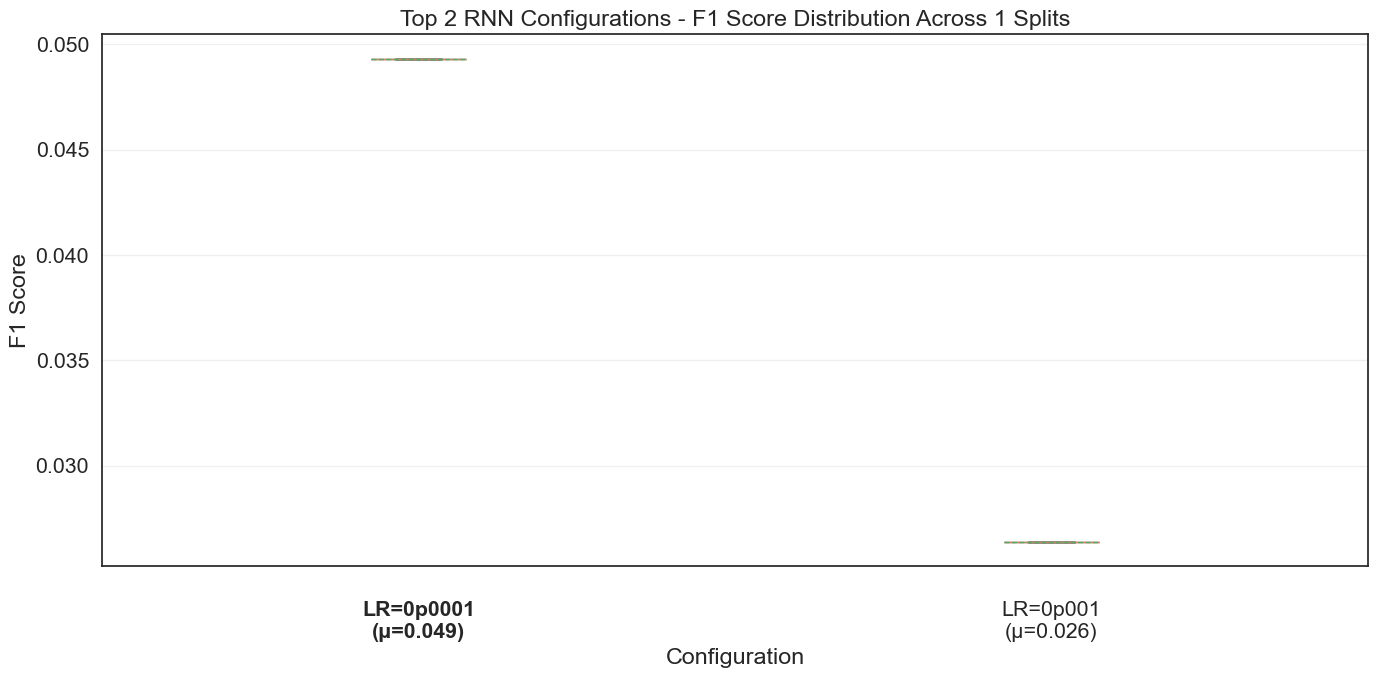

In [93]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [94]:
# --- 1. Combine fixed and best hyperparameters ---
# 'fixed_params' and 'best_config' are loaded from the grid search cell
final_best_params = {**fixed_params, **best_config}

# Generate config string (from grid params only) to find saved model files
best_config_str = "_".join([f"{k}_{v}" for k, v in best_config.items()]).replace('.', 'p')

Evaluating Split 1/1 using best config: learning_rate_0p0001
  Test F1 Score for Split 1: 0.0262

Average metrics across all splits on the test set:
Mean Accuracy: 0.1212 ± 0.0000
Mean Precision: 0.0147 ± 0.0000
Mean Recall: 0.1212 ± 0.0000
Mean F1 score: 0.0262 ± 0.0000


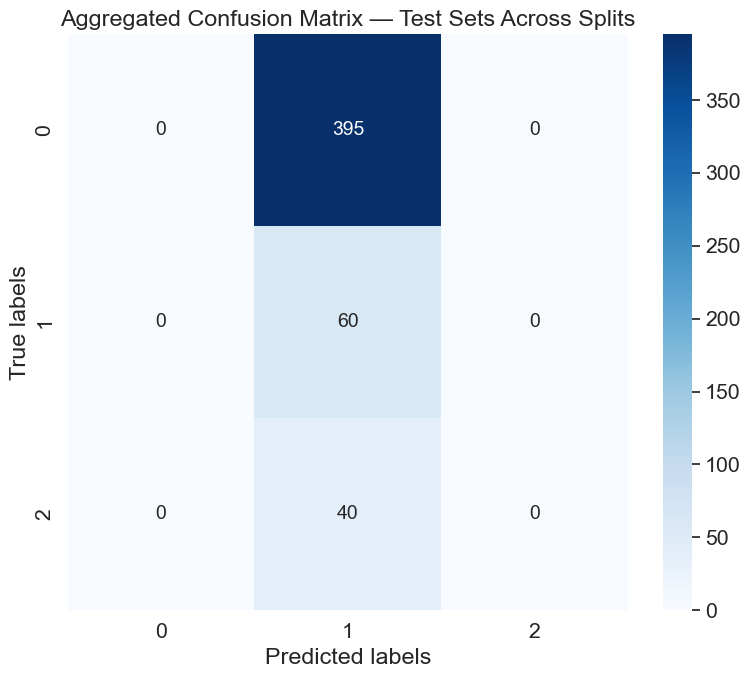

In [95]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Initialise lists for metrics
test_accuracies = []
test_precisions = []
test_recall_scores = []
test_f1_scores = []
all_test_targets = []  # For aggregated confusion matrix
all_test_preds = []  # For aggregated confusion matrix

min_max_scaler = MinMaxScaler()

# --- 2. Begin evaluation loop across the K splits ---
# K, SEED, N_VAL_USERS, N_TEST_USERS are defined globally
for split in range(K):
    print(f"Evaluating Split {split + 1}/{K} using best config: {best_config_str}")

    # --- 3. Regenerate the exact data split for this fold ---
    # This logic must be identical to k_shuffle_split_cross_validation_round_rnn
    rng = np.random.default_rng(SEED + split)
    shuffled = rng.permutation(unique_samples)

    n_train_sample_indexes = len(unique_samples) - N_VAL_SAMPLES - N_TEST_SAMPLES
    train_users = unique_samples[:n_train_sample_indexes]
    val_users = unique_samples[n_train_sample_indexes:n_train_sample_indexes + N_VAL_SAMPLES]
    test_users = unique_samples[n_train_sample_indexes + N_VAL_SAMPLES:]

    df_train = df_dataset_reduced[df_dataset_reduced['sample_index'].isin(train_users)].copy()
    df_test = df_dataset_reduced[df_dataset_reduced['sample_index'].isin(test_users)].copy()

    # Normalise features (fit on THIS split's training data)
    df_train[CONTINUOUS_COLS_REDUCED] = min_max_scaler.fit_transform(df_train[CONTINUOUS_COLS_REDUCED])
    df_test[CONTINUOUS_COLS_REDUCED] = min_max_scaler.fit_transform(df_test[CONTINUOUS_COLS_REDUCED])

    labels_df_split = labels_df[labels_df['sample_index'].isin(test_users)].copy()

    # --- 5. Build test sequences ---
    # Use the best window/stride from final_best_params
    X_test_cont, X_test_cat, y_test = build_sequences(
        df_test,
        labels_df_split,
        continuous_cols=CONTINUOUS_COLS_REDUCED,
        categorical_cols=CATEGORICAL_COLS_REDUCED,
        window=final_best_params['window_size'],
        stride=final_best_params['stride']
    )

    # --- 6. Create the Test DataLoader ---
    test_ds = TensorDataset(torch.from_numpy(X_test_cont), torch.from_numpy(X_test_cat).long(),
                            torch.from_numpy(y_test).long())
    test_loader = make_loader(
        test_ds,
        batch_size=final_best_params['batch_size'],
        shuffle=False,
        drop_last=False
    )

    # Handle empty test sets from user splits
    if len(test_ds) == 0:
        print(f"  WARNING: Test set for split {split + 1} is empty. Skipping.")
        continue

    # --- 7. Initialise the Model ---
    # Use the best architecture parameters from the grid search
    model = RecurrentClassifier(
        continuous_input_size=len(CONTINUOUS_COLS_REDUCED),
        categorical_cardinalities=categorical_cardinalities,
        embedding_dims=embedding_dims,
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        num_classes=num_classes,
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

    # --- 8. Load the model weights for this specific split and config ---
    model_path = f"models/{best_config_str}/split_{split}_model.pt"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  ERROR: Model file not found at {model_path}")
        print(f"  Skipping split {split + 1}.")
        continue

    model.eval()  # Set model to evaluation mode

    # --- 9. Esecuzione inferenza sul test set (continue + categoriche) ---
    split_test_preds, split_test_targets = [], []
    with torch.no_grad():
        for x_cont, x_cat, y in test_loader:
            x_cont = x_cont.to(device)
            x_cat = x_cat.to(device)
            y = y.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x_cont, x_cat)
            preds = logits.argmax(dim=1).cpu().numpy()
            split_test_preds.append(preds)
            split_test_targets.append(y.cpu().numpy())

    split_test_preds = np.concatenate(split_test_preds)
    split_test_targets = np.concatenate(split_test_targets)

    # --- 10. Calculate and store metrics for this split ---
    split_test_acc = accuracy_score(split_test_targets, split_test_preds)
    split_test_prec = precision_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_rec = recall_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_f1 = f1_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)

    print(f"  Test F1 Score for Split {split + 1}: {split_test_f1:.4f}")

    test_accuracies.append(split_test_acc)
    test_precisions.append(split_test_prec)
    test_recall_scores.append(split_test_rec)
    test_f1_scores.append(split_test_f1)

    all_test_targets.extend(split_test_targets)
    all_test_preds.extend(split_test_preds)

# --- 11. After the loop: Print mean metrics and plot confusion matrix ---
print("\nAverage metrics across all splits on the test set:")
print(f"Mean Accuracy: {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
print(f"Mean Precision: {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Mean Recall: {np.mean(test_recall_scores):.4f} ± {np.std(test_recall_scores):.4f}")
print(f"Mean F1 score: {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")

# Generate confusion matrix for the concatenated test sets
cm = confusion_matrix(all_test_targets, all_test_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix — Test Sets Across Splits')
plt.tight_layout()
plt.show()

## **Inference on kaggle dataset**

In [96]:
# 1) Ricava la config migliore e lo split migliore
split_scores = [results[best_config_str].get(f"split_{i}", -1.0) for i in range(K)]
best_split_idx = int(np.argmax(split_scores))

print(f"Miglior configurazione: {best_config_str}")
print(f"Miglior split: {best_split_idx} con F1={split_scores[best_split_idx]:.4f}")

# 2) Istanzia il modello con gli iperparametri migliori
best_model = RecurrentClassifier(
    continuous_input_size=len(CONTINUOUS_COLS_REDUCED),
    categorical_cardinalities=categorical_cardinalities,
    embedding_dims=embedding_dims,
    hidden_size=final_best_params['hidden_size'],
    num_layers=final_best_params['hidden_layers'],
    num_classes=num_classes,
    dropout_rate=final_best_params['dropout_rate'],
    bidirectional=final_best_params['bidirectional'],
    rnn_type=final_best_params['rnn_type']
).to(device)

# 3) Carica i pesi del modello migliore e lo scaler associato
best_model_path = f"models/{best_config_str}/split_{best_split_idx}_model.pt"
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

best_scaler_path = f"models/{best_config_str}/split_{best_split_idx}_scaler.pkl"
scaler = joblib.load(best_scaler_path)

print(f"Modello caricato da {best_model_path}")
print(f"Scaler caricato da {best_scaler_path}")

Miglior configurazione: learning_rate_0p0001
Miglior split: 0 con F1=0.0493
Modello caricato da models/learning_rate_0p0001/split_0_model.pt
Scaler caricato da models/learning_rate_0p0001/split_0_scaler.pkl


In [97]:
submission_path = f"submissions/{EXPERIMENT_NAME}_submission.csv"

In [98]:
# 4) Funzione per creare le sequenze per l'inferenza (senza etichette)
def build_sequences_inference(df, continuous_cols, categorical_cols, window=200, stride=200):
    assert window % stride == 0
    X_cont, X_cat, owners = [], [], []
    for sid, g in df.groupby('sample_index'):
        cont = g[continuous_cols].values
        cat = g[categorical_cols].values
        pad = (window - (len(cont) % window)) % window
        if pad > 0:
            cont = np.concatenate([cont, np.zeros((pad, cont.shape[1]), dtype='float32')], axis=0)
            cat = np.concatenate([cat, np.zeros((pad, cat.shape[1]), dtype='int64')], axis=0)
        i = 0
        while i + window <= len(cont):
            X_cont.append(cont[i:i + window])
            X_cat.append(cat[i:i + window])
            owners.append(sid)
            i += stride
    return np.asarray(X_cont, dtype=np.float32), np.asarray(X_cat, dtype=np.int64), np.asarray(owners, dtype=np.int32)

In [99]:
# 5) Normalizza il kaggle test con lo scaler CORRETTO (caricato sopra), quello relativo allo split migliore
kaggle_test_df_reduced[CONTINUOUS_COLS_REDUCED] = scaler.transform(kaggle_test_df_reduced[CONTINUOUS_COLS_REDUCED])

In [100]:
from collections import Counter

# 6) Costruisci le sequenze per Kaggle test
Xk_cont, Xk_cat, owners = build_sequences_inference(
    kaggle_test_df_reduced,
    continuous_cols=CONTINUOUS_COLS_REDUCED,
    categorical_cols=CATEGORICAL_COLS_REDUCED,
    window=final_best_params['window_size'],
    stride=final_best_params['stride']
)

# 7) Inference sui windows
kaggle_ds = TensorDataset(
    torch.from_numpy(Xk_cont).float(),
    torch.from_numpy(Xk_cat).long()
)
kaggle_loader = make_loader(kaggle_ds, batch_size=final_best_params['batch_size'], shuffle=False, drop_last=False)

all_preds = []
with torch.no_grad():
    for xb_cont, xb_cat in kaggle_loader:
        xb_cont = xb_cont.to(device)
        xb_cat = xb_cat.to(device)
        logits = best_model(xb_cont, xb_cat)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)

all_preds = np.concatenate(all_preds) if len(all_preds) else np.array([], dtype=np.int64)

# 8) Aggrega per sample_index (maggioranza)
preds_per_sample = {}
for sid, p in zip(owners, all_preds):
    preds_per_sample.setdefault(int(sid), []).append(int(p))

final_idx = {sid: Counter(v).most_common(1)[0][0] for sid, v in preds_per_sample.items()}

# 9) Mappa a etichette testuali e crea submission
inv_label_map = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
submission = pd.DataFrame({
    'sample_index': list(final_idx.keys()),
    'label': [inv_label_map[int(v)] for v in final_idx.values()]
}).sort_values('sample_index', kind='stable')

# allinea all’ordine del sample submission
submission = sample_submission_df[['sample_index']].merge(submission, on='sample_index', how='left')

os.makedirs("submissions", exist_ok=True)
submission.to_csv(submission_path, index=False)

print(f"Submission salvata in {submission_path}")

Submission salvata in submissions/gscv_bgru_learningRate_deleteme_submission.csv
